CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [16]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Union

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# Moved additional imports here to make code easier to read.
from common_utils import EarlyStopper, split_dataset, preprocess_dataset


# setting seed
SEED = 42
set_seed(SEED)

Define the model class.

In [2]:
class MLP(nn.Module):
  def __init__(self, in_channels: int, hidden_channels: int, out_channels: int, dropout: float = 0.2) -> None:
    super().__init__()
    self.linear_1 = nn.Linear(in_channels, hidden_channels)
    self.linear_2 = nn.Linear(hidden_channels, hidden_channels)
    self.linear_3 = nn.Linear(hidden_channels, hidden_channels)  
    self.out = nn.Linear(hidden_channels, out_channels)

    self.dropout = nn.Dropout(dropout)
    self.act_fn = nn.ReLU()
    self.out_act_fn = nn.Sigmoid()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.linear_1(x)
    x = self.act_fn(x)
    x = self.dropout(x)

    x = self.linear_2(x)
    x = self.act_fn(x)
    x = self.dropout(x)

    x = self.linear_3(x)
    x = self.act_fn(x)
    x = self.dropout(x)

    x = self.out(x)
    x = self.out_act_fn(x)

    return x

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [3]:
df = pd.read_csv("audio_gtzan.csv")
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])

train_x, train_y, test_x, test_y = split_dataset(df=df, columns_to_drop=["filename", "label"], test_size=0.3, random_state=SEED)
train_x_scaled, test_x_scaled = preprocess_dataset(train_x, test_x)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [17]:
class AudioDataset(Dataset):
  def __init__(self, x: np.ndarray, y: np.ndarray) -> None:
    self.x = torch.from_numpy(x).float()
    self.y = torch.from_numpy(y).float()
  
  def __len__(self) -> int:
    return len(self.x)
  
  def __getitem__(self, index: int) -> Tuple[int, int]:
    return self.x[index], self.y[index]

In [15]:
train_dataset = AudioDataset(train_x_scaled, train_y)
test_dataset = AudioDataset(test_x_scaled, test_y)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Check shapes
print(next(iter(train_dataloader))[0].shape) # (batch_size, num_channels)

NameError: name 'AudioDataset' is not defined

2. Next, define the model, optimizer and loss function.

In [6]:
model = MLP(in_channels=57, hidden_channels=128, out_channels=1).to(dtype=torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [7]:
num_epochs = 100
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
early_stopper = EarlyStopper(patience=3)

for epoch in tqdm.tqdm(range(num_epochs), desc="Training epochs"):
  model.train()

  epoch_loss = 0.0
  epoch_correct = 0
  epoch_total = 0

  # Training
  for x, y in train_dataloader:
    optimizer.zero_grad()
    outputs = model(x.float()) # (batch_size, 1)
    y = y.unsqueeze(1) # (batch_size,) -> (batch_size, 1)

    loss = loss_fn(outputs, y.float())
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * x.size(0)
    predictions = (outputs > 0.5).float()
    epoch_correct += (predictions == y).sum().item()
    epoch_total += y.size(0)

  training_losses.append(epoch_loss / len(train_dataset))
  training_accuracies.append(epoch_correct / epoch_total)

  # Testing
  model.eval()
  test_loss = 0.0
  test_correct = 0
  test_total = 0

  with torch.no_grad():
    for x, y in test_dataloader:
      outputs = model(x.float())
      y = y.unsqueeze(1)

      loss = loss_fn(outputs, y.float())
      test_loss += loss.item() * x.size(0)
      predictions = (outputs > 0.5).float()
      test_correct += (predictions == y).sum().item()
      test_total += y.size(0)

  testing_losses.append(test_loss / len(test_dataset))
  testing_accuracies.append(test_correct / test_total)

  # Early Stopping
  if early_stopper.early_stop(testing_losses[-1]):
    print("Stopping Early")
    break      

Training epochs:  13%|█▎        | 13/100 [00:00<00:06, 14.20it/s]

Stopping Early


> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

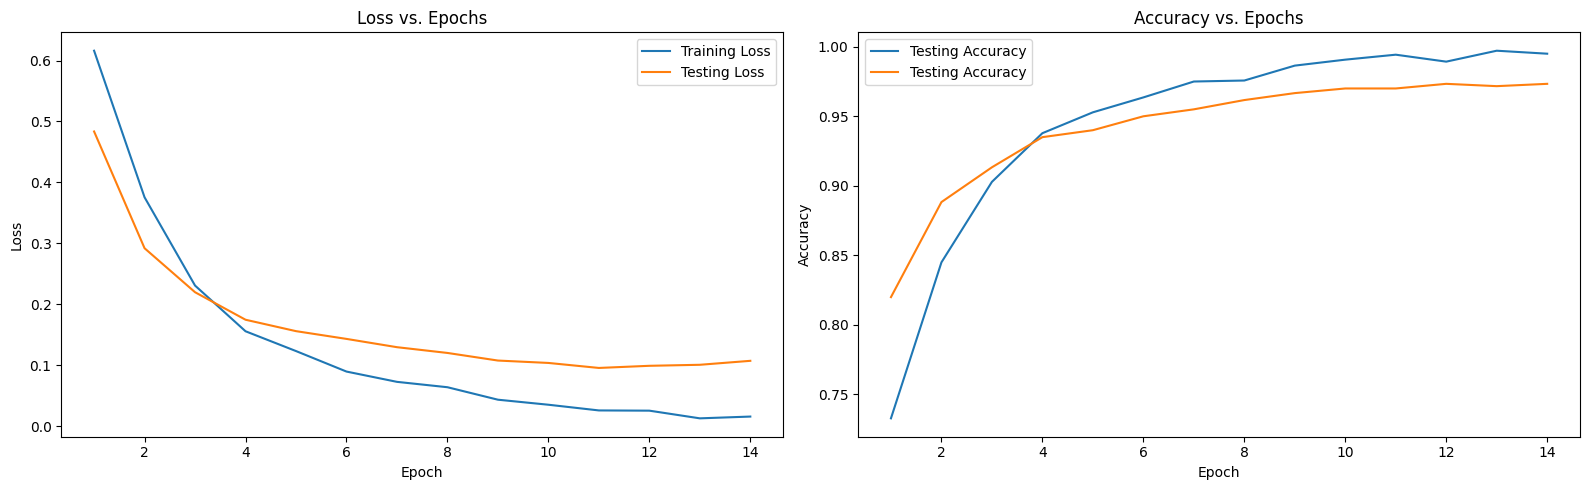

In [8]:
num_epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(16, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(num_epochs, training_losses, label="Training Loss")
plt.plot(num_epochs, testing_losses, label="Testing Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(num_epochs, training_accuracies, label="Testing Accuracy")
plt.plot(num_epochs, testing_accuracies, label="Testing Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

<div style="color:lightgreen">
  <bold style="font-weight:bold">Loss vs. Epochs</bold>
  <p>The sharp drop at the beginning tells us that our model is fitting well to our dataset. At around the 4th epoch we find that our testing loss starts to exceed the training loss. This tells us that some overfitting is starting to happen. After the 4th epoch, we also see that we're getting a noticible, but not too large of a difference between our training and testing losses, indicating that our model is still generalizing pretty well.</p>
  <p>The losses are also starting to converge to 0, which indicates that we're getting great performance out of our model</p>

  <bold style="font-weight:bold">Accuracy vs. Epochs</bold>
  <p>The accuracy graph gives us the same information that we get from our <i>"Loss vs. Epoch"</i> graph, showing that at around the 4th epoch, we start to overfit a little bit but still generalize well enough to have a high accuracy on our test data</p>
</div>

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [9]:
import pandas as pd
import numpy as np
from common_utils import MLP
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [10]:
# Re-importing the dataset
label_encoder = LabelEncoder()
df = pd.read_csv("audio_gtzan.csv")
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])
df["label"] = label_encoder.fit_transform(df["label"])
df = df.drop("filename", axis=1)

x = df.drop("label", axis=1)
y = df["label"]

In [11]:
batch_sizes = [32, 64, 128, 256]
X_train_scaled_dict = {}
X_val_scaled_dict = {}
y_train_dict = {}
y_val_dict = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for batch_size in batch_sizes:
  X_train_scaled_dict[batch_size] = []
  X_val_scaled_dict[batch_size] = []
  y_train_dict[batch_size] = []
  y_val_dict[batch_size] = []

  for (train_index, val_index) in skf.split(x, y):
    scaler = preprocessing.StandardScaler()
    train_x, val_x = x.iloc[train_index], x.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Scale the x values
    train_x_scaled = scaler.fit_transform(train_x)
    val_x_scaled = scaler.transform(val_x)

    X_train_scaled_dict[batch_size].append(train_x_scaled)
    X_val_scaled_dict[batch_size].append(val_x_scaled)
    y_train_dict[batch_size].append(train_y.to_numpy())
    y_val_dict[batch_size].append(val_y.to_numpy())

In [12]:
print(X_train_scaled_dict.get(32)[0].shape)
print(y_train_dict.get(32)[0].shape)
print(X_val_scaled_dict.get(32)[0].shape)
print(y_val_dict.get(32)[0].shape)

(1600, 57)
(1600,)
(400, 57)
(400,)


2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [13]:
batch_average_accuracies = []
batch_final_epoch_times = []

for batch_size in batch_sizes:
  
  fold_accuracies = []
  final_fold_epoch_time = 0
  for i in range(len(X_train_scaled_dict.get(batch_size))):
    train_dataset = AudioDataset(X_train_scaled_dict.get(batch_size)[i], y_train_dict.get(batch_size)[i])
    val_dataset = AudioDataset(X_val_scaled_dict.get(batch_size)[i], y_val_dict.get(batch_size)[i])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Re-initialize the model
    model = MLP(in_channels=57, hidden_channels=128, out_channels=1).to(dtype=torch.float32)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.BCELoss()
    early_stopper = EarlyStopper(patience=3)

    num_epochs = 100
    training_losses = []
    training_accuracies = []
    testing_losses = []
    testing_accuracies = []

    for epochs in tqdm.tqdm(range(num_epochs), desc="Training epochs"):
      model.train()
      start_time = time.time()

      epoch_loss = 0.0
      epoch_correct = 0
      epoch_total = 0

      for x, y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(x.float()) # (batch_size, 1)
        y = y.unsqueeze(1) # (batch_size,) -> (batch_size, 1)

        loss = loss_fn(outputs, y.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        predictions = (outputs > 0.5).float()
        epoch_correct += (predictions == y).sum().item()
        epoch_total += y.size(0)

      training_losses.append(epoch_loss / len(train_dataset))
      training_accuracies.append(epoch_correct / epoch_total)

      # Validation
      model.eval()
      test_loss = 0.0
      test_correct = 0
      test_total = 0

      with torch.no_grad():
        for x, y in val_dataloader:
          outputs = model(x.float())
          y = y.unsqueeze(1)

          loss = loss_fn(outputs, y.float())
          test_loss += loss.item() * x.size(0)
          predictions = (outputs > 0.5).float()
          test_correct += (predictions == y).sum().item()
          test_total += y.size(0)

      testing_losses.append(test_loss / len(val_dataset))
      testing_accuracies.append(test_correct / test_total)

      end_time = time.time()
      final_fold_epoch_time = end_time - start_time

      # Early Stopping
      if early_stopper.early_stop(testing_losses[-1]):
        print("Stopping Early")
        break

    fold_accuracies.append(np.mean(testing_accuracies))
  
  batch_final_epoch_times.append(final_fold_epoch_time)
  batch_average_accuracies.append(np.mean(fold_accuracies))

Training epochs:  10%|█         | 10/100 [00:01<00:16,  5.49it/s]


Stopping Early


Training epochs:  16%|█▌        | 16/100 [00:02<00:13,  6.20it/s]


Stopping Early


Training epochs:   7%|▋         | 7/100 [00:01<00:18,  5.11it/s]


Stopping Early


Training epochs:   8%|▊         | 8/100 [00:01<00:14,  6.22it/s]


Stopping Early


Training epochs:   8%|▊         | 8/100 [00:01<00:16,  5.57it/s]


Stopping Early


Training epochs:  15%|█▌        | 15/100 [00:01<00:08,  9.96it/s]


Stopping Early


Training epochs:  14%|█▍        | 14/100 [00:01<00:09,  9.19it/s]


Stopping Early


Training epochs:  15%|█▌        | 15/100 [00:01<00:08,  9.60it/s]


Stopping Early


Training epochs:  13%|█▎        | 13/100 [00:01<00:07, 10.88it/s]


Stopping Early


Training epochs:   8%|▊         | 8/100 [00:00<00:09,  9.60it/s]


Stopping Early


Training epochs:  20%|██        | 20/100 [00:01<00:05, 13.89it/s]


Stopping Early


Training epochs:  14%|█▍        | 14/100 [00:01<00:06, 13.74it/s]


Stopping Early


Training epochs:  16%|█▌        | 16/100 [00:01<00:05, 15.29it/s]


Stopping Early


Training epochs:  12%|█▏        | 12/100 [00:00<00:05, 14.74it/s]


Stopping Early


Training epochs:  17%|█▋        | 17/100 [00:01<00:06, 12.47it/s]


Stopping Early


Training epochs:  35%|███▌      | 35/100 [00:01<00:03, 18.44it/s]


Stopping Early


Training epochs:  21%|██        | 21/100 [00:01<00:04, 16.71it/s]


Stopping Early


Training epochs:  21%|██        | 21/100 [00:01<00:04, 18.43it/s]


Stopping Early


Training epochs:  23%|██▎       | 23/100 [00:01<00:04, 18.74it/s]


Stopping Early


Training epochs:  27%|██▋       | 27/100 [00:01<00:03, 18.39it/s]

Stopping Early


3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

In [14]:
print(batch_sizes)
print(batch_average_accuracies)
print(batch_final_epoch_times)

[32, 64, 128, 256]
[np.float64(0.9714134729649435), np.float64(0.9667134920634922), np.float64(0.9572407886231415), np.float64(0.9537806637806637)]
[0.1530163288116455, 0.08852887153625488, 0.07738137245178223, 0.053179025650024414]


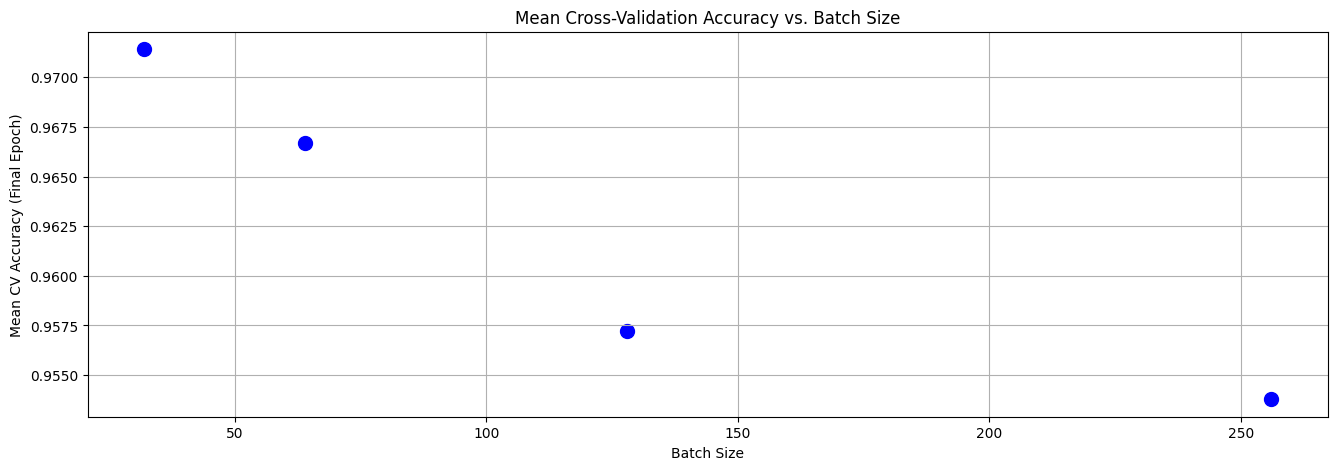

In [15]:
plt.figure(figsize=(16, 5))
plt.scatter(batch_sizes, batch_average_accuracies, color="blue", s=100)
plt.title("Mean Cross-Validation Accuracy vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Mean CV Accuracy (Final Epoch)")
plt.grid(True)
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

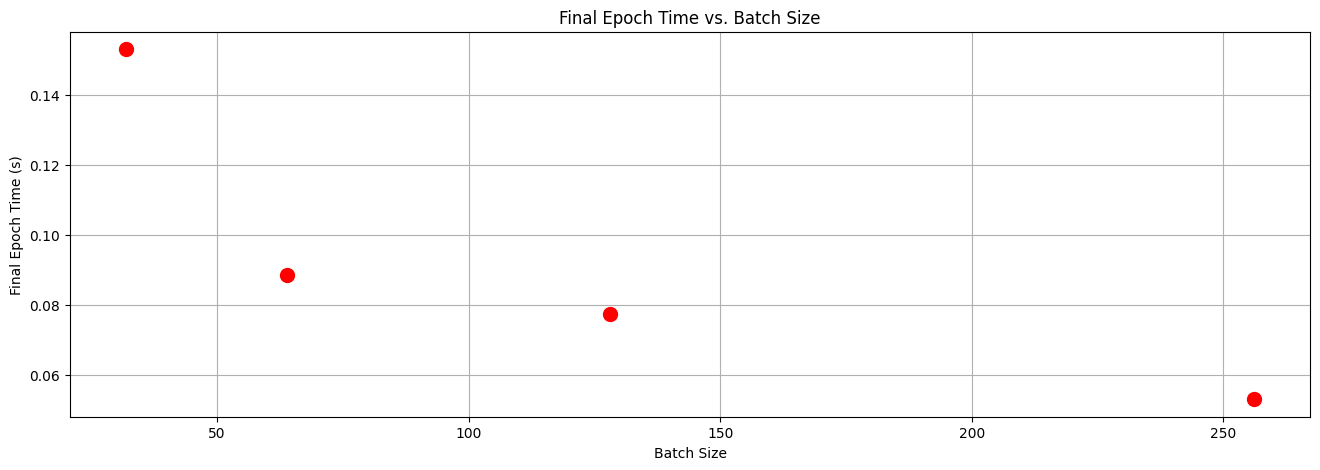

In [16]:
plt.figure(figsize=(16, 5))
plt.scatter(batch_sizes, batch_final_epoch_times, color="red", s=100)
plt.title("Final Epoch Time vs. Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Final Epoch Time (s)")
plt.grid(True)
plt.show()

5. Select the optimal batch size and state a reason for your selection.

<div style="color:lightgreen">   
<bold style="font-weight:bold">Selected Batch Size: 32 </bold>   
<p>I decided to choose the batch size of 32 as, it tends to give us a better average accuracy compared to the other batch sizes.</p>
<p>I also note that a batch size of 32 takes significantly longer than the other batch sizes but I believe that this is a justifiable compromise as our training dataset is pretty small and doesn't take that long to train on a batch size of 32 anyways.</p>
</div>

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [18]:
import numpy as np
import pandas as pd
from common_utils import MLP
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
SEED = 42

# Re-importing the dataset
label_encoder = LabelEncoder()
df = pd.read_csv("audio_gtzan.csv")
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])
df["label"] = label_encoder.fit_transform(df["label"])
df = df.drop("filename", axis=1)

x = df.drop("label", axis=1)
y = df["label"]

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [19]:
num_hidden_channels = [64, 128, 256]
train_x_scaled_folds = []
val_x_scaled_folds = []
train_y_folds = []
val_y_folds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for (train_index, val_index) in skf.split(x, y):
  scaler = preprocessing.StandardScaler()
  train_x, val_x = x.iloc[train_index], x.iloc[val_index]
  train_y, val_y = y.iloc[train_index], y.iloc[val_index]

  # Scale the x values
  train_x_scaled = scaler.fit_transform(train_x)
  val_x_scaled = scaler.transform(val_x)

  train_x_scaled_folds.append(train_x_scaled)
  val_x_scaled_folds.append(val_x_scaled)
  train_y_folds.append(train_y.to_numpy())
  val_y_folds.append(val_y.to_numpy())

In [12]:
print(train_x_scaled_folds[0].shape)
print(train_y_folds[0].shape)
print(val_x_scaled_folds[0].shape)
print(val_y_folds[0].shape)

(1600, 57)
(1600,)
(400, 57)
(400,)


In [ ]:
# Training the model
hidden_average_accuracies = []
hidden_final_epoch_times = []

for hidden_channels in num_hidden_channels:
  fold_accuracies = []
  final_fold_epoch_time = 0
  for i in range(len(train_x_scaled_folds)):
    train_dataset = AudioDataset(train_x_scaled_folds[i], train_y_folds[i])
    val_dataset = AudioDataset(val_x_scaled_folds[i], val_y_folds[i])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Re-initialize the model
    model = MLP(in_channels=57, hidden_channels=128, out_channels=1).to(dtype=torch.float32)
    model.linear_1 = nn.Linear(57, hidden_channels)
    model.linear_2 = nn.Linear(hidden_channels, 128)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.BCELoss()
    early_stopper = EarlyStopper(patience=3)

    num_epochs = 100
    training_losses = []
    training_accuracies = []
    testing_losses = []
    testing_accuracies = []

    for epochs in tqdm.tqdm(range(num_epochs), desc="Training epochs"):
      model.train()
      start_time = time.time()

      epoch_loss = 0.0
      epoch_correct = 0
      epoch_total = 0

      for x, y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(x.float()) # (batch_size, 1)
        y = y.unsqueeze(1) # (batch_size,) -> (batch_size, 1)

        loss = loss_fn(outputs, y.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x.size(0)
        predictions = (outputs > 0.5).float()
        epoch_correct += (predictions == y).sum().item()
        epoch_total += y.size(0)

      training_losses.append(epoch_loss / len(train_dataset))
      training_accuracies.append(epoch_correct / epoch_total)

      # Validation
      model.eval()
      test_loss = 0.0
      test_correct = 0
      test_total = 0

      with torch.no_grad():
        for x, y in val_dataloader:
          outputs = model(x.float())
          y = y.unsqueeze(1)

          loss = loss_fn(outputs, y.float())
          test_loss += loss.item() * x.size(0)
          predictions = (outputs > 0.5).float()
          test_correct += (predictions == y).sum().item()
          test_total += y.size(0)

      testing_losses.append(test_loss / len(val_dataset))
      testing_accuracies.append(test_correct / test_total)

      end_time = time.time()
      final_fold_epoch_time = end_time - start_time

      # Early Stopping
      if early_stopper.early_stop(testing_losses[-1]):
        print("Stopping Early")
        break

    fold_accuracies.append(np.mean(testing_accuracies))

  hidden_final_epoch_times.append(final_fold_epoch_time)
  hidden_average_accuracies.append(np.mean(fold_accuracies))

Training epochs:   9%|▉         | 9/100 [00:02<00:28,  3.22it/s]


Stopping Early


Training epochs:  17%|█▋        | 17/100 [00:05<00:26,  3.19it/s]


Stopping Early


Training epochs:  14%|█▍        | 14/100 [00:03<00:19,  4.31it/s]


Stopping Early


Training epochs:  10%|█         | 10/100 [00:02<00:19,  4.58it/s]


Stopping Early


Training epochs:   9%|▉         | 9/100 [00:01<00:16,  5.63it/s]


Stopping Early


Training epochs:  10%|█         | 10/100 [00:01<00:17,  5.11it/s]


Stopping Early


Training epochs:  10%|█         | 10/100 [00:01<00:16,  5.34it/s]


Stopping Early


Training epochs:  15%|█▌        | 15/100 [00:02<00:15,  5.58it/s]


Stopping Early


Training epochs:   7%|▋         | 7/100 [00:01<00:23,  3.93it/s]


Stopping Early


Training epochs:  11%|█         | 11/100 [00:02<00:16,  5.46it/s]


Stopping Early


Training epochs:   8%|▊         | 8/100 [00:01<00:18,  4.86it/s]


Stopping Early


Training epochs:  10%|█         | 10/100 [00:01<00:17,  5.24it/s]


Stopping Early


Training epochs:  10%|█         | 10/100 [00:01<00:17,  5.04it/s]


Stopping Early


Training epochs:   8%|▊         | 8/100 [00:01<00:17,  5.23it/s]


Stopping Early


Training epochs:   7%|▋         | 7/100 [00:01<00:19,  4.83it/s]

Stopping Early


In [21]:
print(num_hidden_channels)
print(hidden_average_accuracies)
print(hidden_final_epoch_times)

[64, 128, 256]
[np.float64(0.9704838383838383), np.float64(0.9731467803030303), np.float64(0.9732449494949496)]
[0.15928316116333008, 0.17572450637817383, 0.19582772254943848]


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

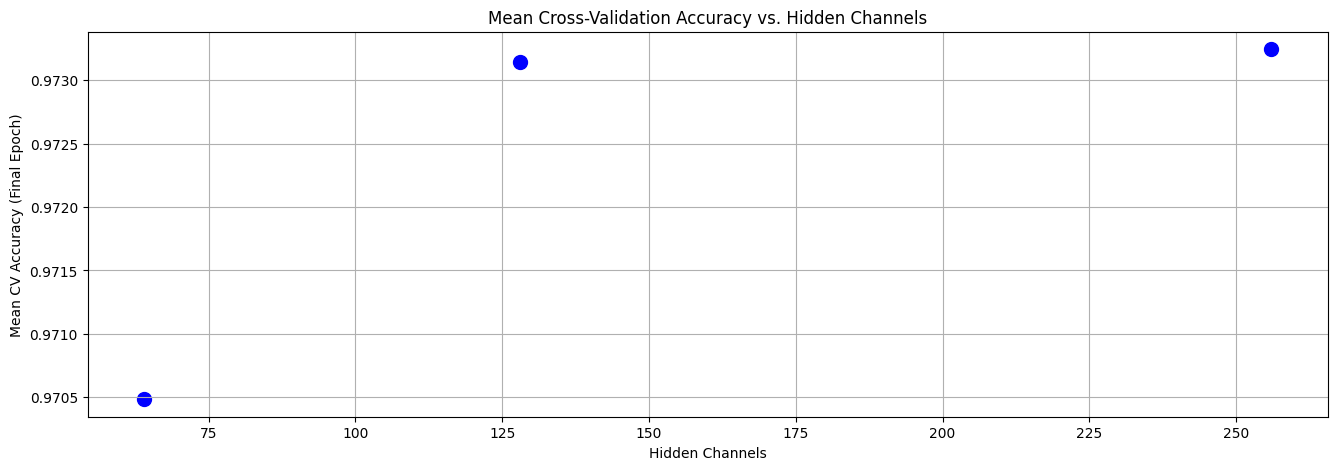

In [22]:
plt.figure(figsize=(16, 5))
plt.scatter(num_hidden_channels, hidden_average_accuracies, color="blue", s=100)
plt.title("Mean Cross-Validation Accuracy vs. Hidden Channels")
plt.xlabel("Hidden Channels")
plt.ylabel("Mean CV Accuracy (Final Epoch)")
plt.grid(True)
plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

<div style="color:lightgreen">
<bold style="font-weight:bold">Selected neuron count: 128</bold>
<p>I decided that 128 neurons would be best because of the difference in accuracies between 256 and 128 neurons is pretty small compared to the difference between 64 and 128. Since we also know that we want to use a simpler model where possible, I decided not to use 256 neurons. A small trade off in neurons for possibly better generalization in our model. </p>
</div>

In [23]:
# Re-importing the dataset
df = pd.read_csv("audio_gtzan.csv") # Same code as part 1
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])

train_x, train_y, test_x, test_y = split_dataset(df=df, columns_to_drop=["filename", "label"], test_size=0.3, random_state=SEED)
train_x_scaled, test_x_scaled = preprocess_dataset(train_x, test_x)

# Create datasets and dataloaders
train_dataset = AudioDataset(train_x_scaled, train_y)
test_dataset = AudioDataset(test_x_scaled, test_y)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
# Train the model with with the selected best parameters
model = MLP(in_channels=57, hidden_channels=128, out_channels=1).to(dtype=torch.float32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()
early_stopper = EarlyStopper(patience=3)

num_epochs = 100
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []

for epochs in tqdm.tqdm(range(num_epochs), desc="Training epochs"):
  model.train()

  epoch_loss = 0.0
  epoch_correct = 0
  epoch_total = 0

  for x, y in train_dataloader:
    optimizer.zero_grad()
    outputs = model(x.float()) # (batch_size, 1)
    y = y.unsqueeze(1) # (batch_size,) -> (batch_size, 1)

    loss = loss_fn(outputs, y.float())
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * x.size(0)
    predictions = (outputs > 0.5).float()
    epoch_correct += (predictions == y).sum().item()
    epoch_total += y.size(0)

  training_losses.append(epoch_loss / len(train_dataset))
  training_accuracies.append(epoch_correct / epoch_total)

  # Validation
  model.eval()
  test_loss = 0.0
  test_correct = 0
  test_total = 0

  with torch.no_grad():
    for x, y in val_dataloader:
      outputs = model(x.float())
      y = y.unsqueeze(1)

      loss = loss_fn(outputs, y.float())
      test_loss += loss.item() * x.size(0)
      predictions = (outputs > 0.5).float()
      test_correct += (predictions == y).sum().item()
      test_total += y.size(0)

  testing_losses.append(test_loss / len(val_dataset))
  testing_accuracies.append(test_correct / test_total)

  # Early Stopping
  if early_stopper.early_stop(testing_losses[-1]):
    print("Stopping Early")
    break

Training epochs:  12%|█▏        | 12/100 [00:02<00:15,  5.53it/s]

Stopping Early


> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

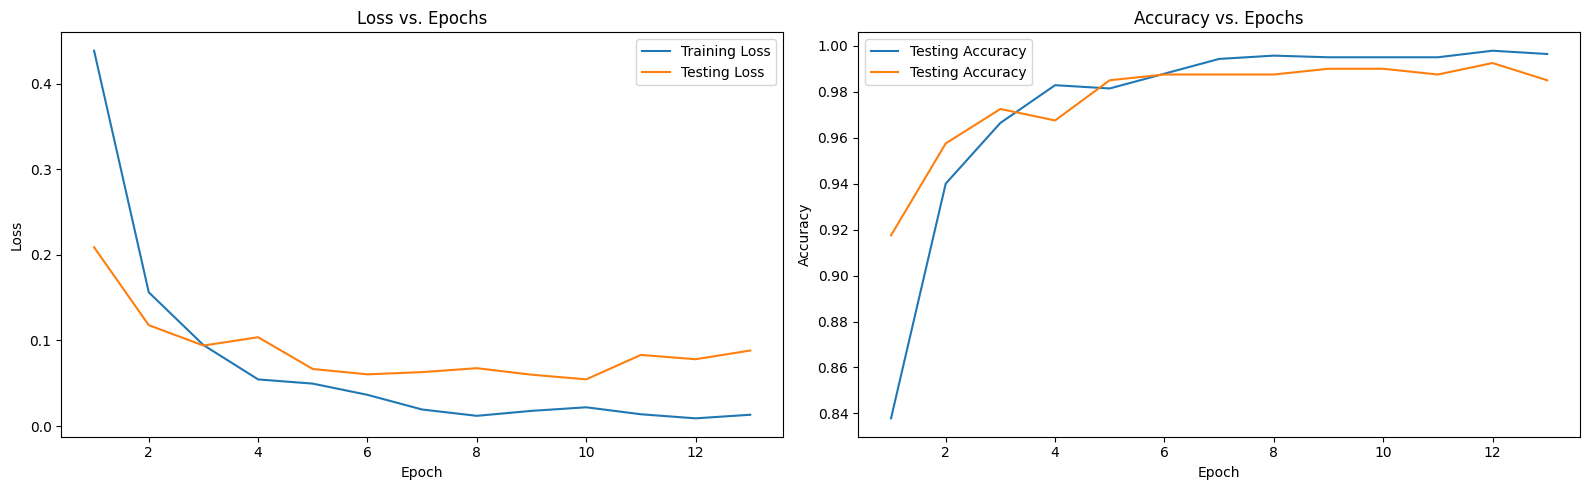

In [27]:
num_epochs = range(1, len(training_losses) + 1)
plt.figure(figsize=(16, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(num_epochs, training_losses, label="Training Loss")
plt.plot(num_epochs, testing_losses, label="Testing Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(num_epochs, training_accuracies, label="Testing Accuracy")
plt.plot(num_epochs, testing_accuracies, label="Testing Accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [30]:
import os
from common_utils import extract_features, MLP

> Install and import shap

In [28]:
%%cmd
call .venv\Scripts\activate.bat
pip install shap

Microsoft Windows [Version 10.0.26100.3194]
(c) Microsoft Corporation. All rights reserved.

(.venv) c:\Users\Shun Jie\Documents\Github\music-genre-classification>call .venv\Scripts\activate.bat

(.venv) c:\Users\Shun Jie\Documents\Github\music-genre-classification>pip install shap



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



(.venv) c:\Users\Shun Jie\Documents\Github\music-genre-classification>

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [28]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [ ]:
df = extract_features("audio_test.wav")
size_row = df.shape[0]
size_column = df.shape[1]

> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [32]:
test = df.drop("filename", axis=1)
scaler = preprocessing.StandardScaler()
test_scaled = scaler.fit_transform(test)
print(test_scaled.shape)

(1, 57)


2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [ ]:
# Using the model that we previously trained using the chose batch_size and hidde_channels
with torch.no_grad():
  model.eval()
  outputs = model(torch.from_numpy(test_scaled).float())
  pred_label = int(outputs > 0.5)

0


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [86]:
import shap

# Re-importing the dataset
df = pd.read_csv("audio_gtzan.csv") # Same code as part 1
df["label"] = df["filename"].apply(lambda x: x.split(".")[0])

train_x, train_y, test_x, test_y = split_dataset(df=df, columns_to_drop=["filename", "label"], test_size=0.3, random_state=SEED)
train_x_scaled, test_x_scaled = preprocess_dataset(train_x, test_x)

model.eval()
explainer = shap.DeepExplainer(model, torch.Tensor(train_x_scaled).float())
shap_values = explainer.shap_values(torch.from_numpy(test_scaled).float(), check_additivity=False).squeeze()

shap.initjs()
feature_names = df.drop(["filename", "label"], axis=1).columns
shap.force_plot(explainer.expected_value[0], shap_values, test_scaled, feature_names=feature_names)

<div style="color:lightgreen">
Few of the most important features include <bold style="font-weight:bold">mfcc20_var, mfcc3_mean, mfcc12_mean, perceptr_var and mfcc9_var</bold>
We can tell this because they take up the most space inside the force plot.
 <bold style="font-weight:bold">mfcc20_var, mfcc3_mean and mfcc12_mean </bold> pull the model to do more negative predictions while <bold style="font-weight:bold">perceptr_var and mfcc9_var</bold> pull the model to do more positive predictions.
</div>